## Retail Store Sales Forecasting with Neural Networks - Prophet method
## By Yasaman Ensafi - 500913843
### Ryerson Data Science and Analytics (MSc)
#### 2019

## Import libraries

In [106]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

## Load Dataset

In [107]:
data= pd.read_excel('Sample_Superstore.xls')

## Edit columns names

In [108]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [109]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales data by date

In [110]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [111]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [112]:
#Resampling the data on monthly frequency
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()

#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

### Train and test split

In [147]:
X = df
train_size = int(len(X) * 0.75)
trainset, testset= X[0:train_size], X[train_size:]

In [148]:
#df_furniture = pd.DataFrame({'order_date':df.index, 'sales':df.values})
df_furniture_train = pd.DataFrame({'order_date':trainset.index, 'sales':trainset.values})

In [149]:
warnings.filterwarnings("ignore")
from fbprophet import Prophet
#df_furniture = df_furniture.rename(columns={'order_date': 'ds', 'sales': 'y'})
df_furniture_train = df_furniture_train.rename(columns={'order_date': 'ds', 'sales': 'y'})

In [150]:
# set the uncertainty interval to 95% (Prophet default is 80%)
furniture_model = Prophet(interval_width=0.95)
#furniture_model.fit(df_furniture)
furniture_model.fit(df_furniture_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [151]:
furniture_forecast = furniture_model.make_future_dataframe(periods=12, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

<Figure size 1296x432 with 0 Axes>

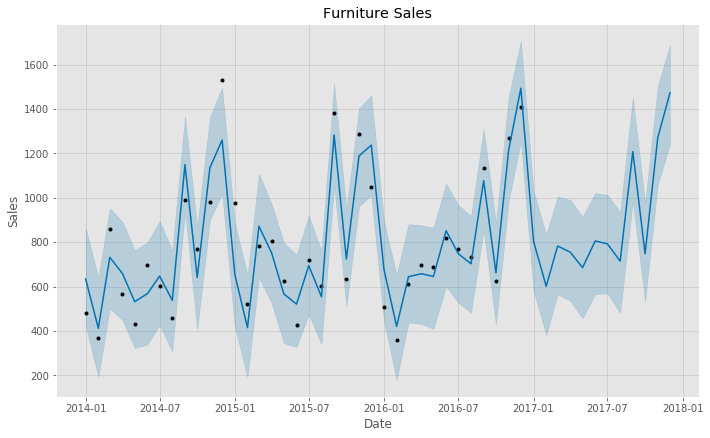

In [152]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

In [159]:
#furniture_forecast

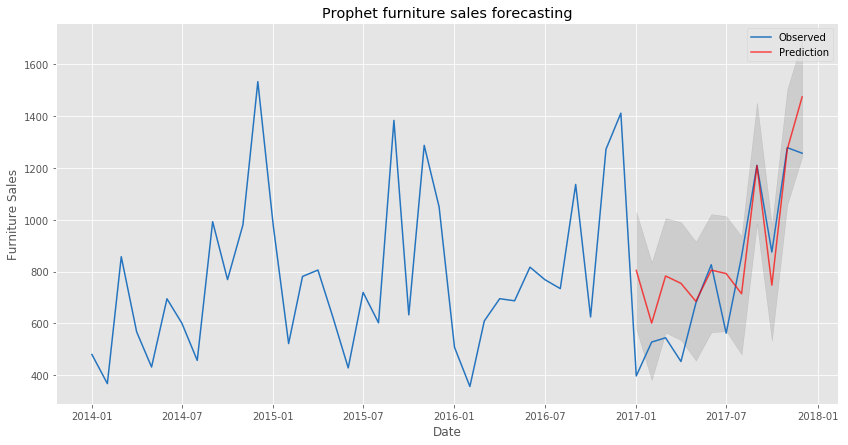

In [154]:
rcParams['figure.figsize'] = 14, 7
plt.plot(df.index, df.values,label='Observed',color='#2574BF')
plt.plot(df[36:48].index,furniture_forecast[36:48]['yhat'].values,label='Prediction', alpha= 0.7, color='red')
plt.fill_between(df[36:48].index,
                #lower sales
                furniture_forecast[36:48]['yhat_lower'].values,
                #upper sales
                furniture_forecast[36:48]['yhat_upper'].values, color='k', alpha=0.1)
plt.title('Prophet furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [155]:
def performance(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [156]:
performance(df_furniture[36:]['y'], furniture_forecast[36:48]['yhat'])

 The MSE of forecasts is 37992.52
 The RMSE of forecasts is 194.92
 The MAPE of forecasts is 26.67


### Second model

In [190]:
#add holidays
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2016-01-01', '2017-01-01'])})  
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2015-12-25', '2016-12-25'])})
us_public_holidays = pd.concat([ny, christ])
# more accurate without holidays!
furniture_model2 = Prophet(yearly_seasonality=True, holidays=us_public_holidays)
#furniture_model2.fit(df_furniture)
furniture_model2.fit(df_furniture_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [191]:
furniture_forecast2 = furniture_model2.make_future_dataframe(periods=36, freq='MS')
furniture_forecast2 = furniture_model2.predict(furniture_forecast2)

<Figure size 1296x432 with 0 Axes>

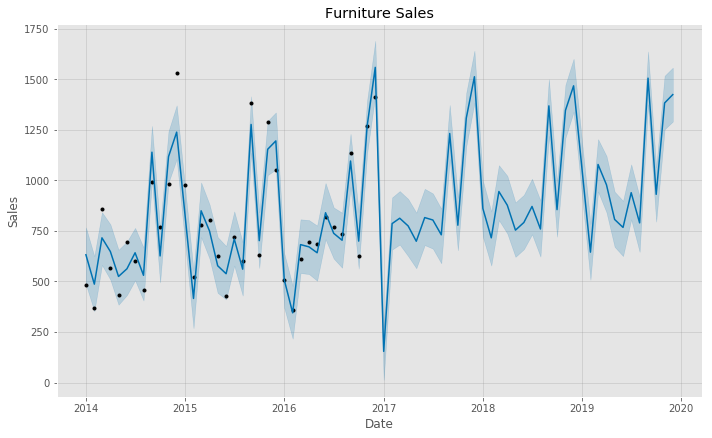

In [192]:
plt.figure(figsize=(18, 6))
furniture_model2.plot(furniture_forecast2, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

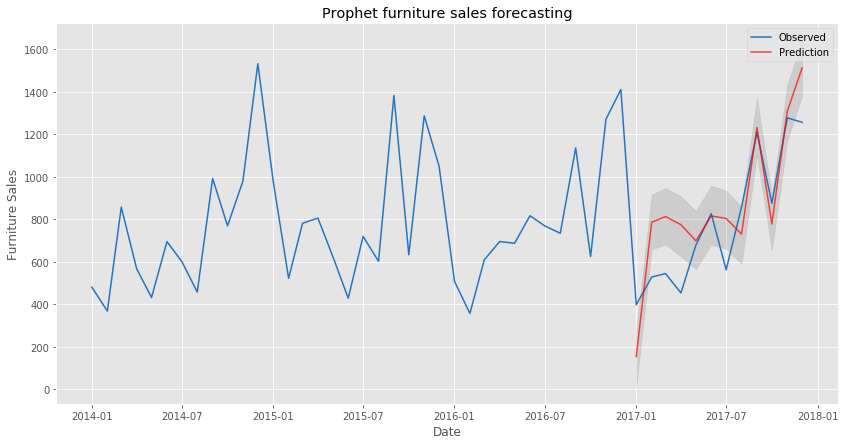

In [193]:
rcParams['figure.figsize'] = 14, 7
plt.plot(df.index, df.values,label='Observed',color='#2574BF')
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prediction', alpha= 0.7, color='red')
plt.fill_between(df[36:48].index,
                #lower sales
                furniture_forecast2[36:48]['yhat_lower'].values,
                #upper sales
                furniture_forecast2[36:48]['yhat_upper'].values, color='k', alpha=0.1)
plt.title('Prophet furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

'The second function Prophet.plot_components might be much more useful in our case. \nIt allows us to observe different components of the model separately: \ntrend, yearly and weekly seasonality. In addition, \nif you supply information about holidays and events to your model, they will also be shown in this plot.'

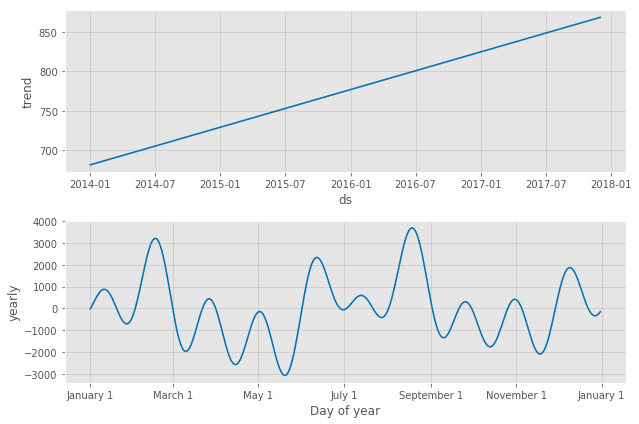

In [194]:
furniture_model.plot_components(furniture_forecast);
'''The second function Prophet.plot_components might be much more useful in our case. 
It allows us to observe different components of the model separately: 
trend, yearly and weekly seasonality. In addition, 
if you supply information about holidays and events to your model, they will also be shown in this plot.'''

In [195]:
performance(df_furniture[36:]['y'], furniture_forecast2[36:48]['yhat'])

 The MSE of forecasts is 37696.67
 The RMSE of forecasts is 194.16
 The MAPE of forecasts is 27.32


### Third model

In [176]:
furniture_model3 = Prophet(weekly_seasonality=False)
furniture_model3.add_seasonality(name='monthly', period=12, fourier_order=5)
#furniture_model3.fit(df_furniture)
furniture_model3.fit(df_furniture_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [177]:
furniture_forecast3 = furniture_model3.make_future_dataframe(periods=36, freq='MS')
furniture_forecast3 = furniture_model3.predict(furniture_forecast3)

<Figure size 1296x432 with 0 Axes>

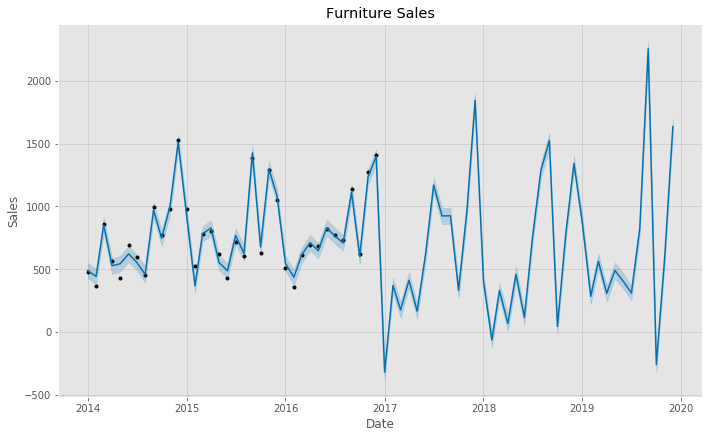

In [178]:
plt.figure(figsize=(18, 6))
furniture_model3.plot(furniture_forecast3, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

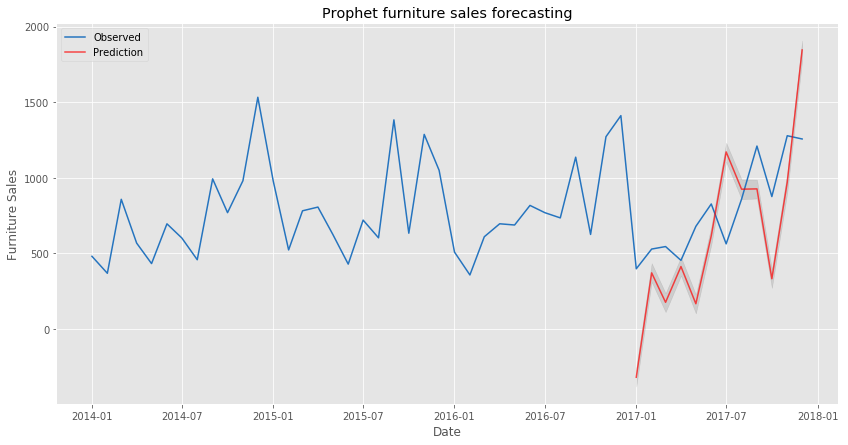

In [179]:
rcParams['figure.figsize'] = 14, 7
plt.plot(df.index, df.values,label='Observed',color='#2574BF')
plt.plot(df[36:48].index,furniture_forecast3[36:48]['yhat'].values,label='Prediction', alpha= 0.7, color='red')
plt.fill_between(df[36:48].index,
                #lower sales
                furniture_forecast3[36:48]['yhat_lower'].values,
                #upper sales
                furniture_forecast3[36:48]['yhat_upper'].values, color='k', alpha=0.1)
plt.title('Prophet furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [182]:
performance(df_furniture[36:]['y'], furniture_forecast3[36:48]['yhat'])

 The MSE of forecasts is 181281.05
 The RMSE of forecasts is 425.77
 The MAPE of forecasts is 55.02
